# Données de l'IREP et Devoir¶

# I. Création du jeu de données

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import urllib.request
import zipfile
from tqdm import tqdm
from pyproj import Proj, transform
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import numpy

### Téléchargement des données

On commence par télécharger toutes les données. 

En TP vous avez téléchargé manuellement le .zip correspondant à chaque année, puis vous l'avez renommé et dézippé. C'est fastidieux ! 

Dans la cellule suivante je vous montre comment le faire de manière automatisée.

In [6]:
import requests

headers = {
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'DNT': '1',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
    'Referer': 'http://www.georisques.gouv.fr/dossiers/irep/telechargement',
    'Accept-Encoding': 'gzip, deflate',
    'Accept-Language': 'en-US,en;q=0.9,fr-FR;q=0.8,fr;q=0.7,ru;q=0.6,de;q=0.5,pt;q=0.4',
}

url = 'http://www.georisques.gouv.fr/irep/data/'
for i in tqdm(range(2003,2018)):
    response = requests.get(url+str(i), headers=headers, verify=False)
    with open('./'+str(i)+'.zip', mode='wb') as localfile:
        localfile.write(response.content)
        
    with zipfile.ZipFile('./'+str(i)+'.zip',"r") as zip_ref:
        zip_ref.extractall("./data/"+str(i)+'/')

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:32<00:00,  2.17s/it]


Explications:

Pour savoir comment j'ai trouvé la requête, consultez [ce lien](https://www.alexkras.com/copy-any-api-call-as-curl-request-with-chrome-developer-tools/).  
On convertit la commande cURL en requête Python en passant par [ce site](https://curl.trillworks.com/#python).   
J'ai supprimé les cookies car ils sont inutiles.  

On enregistre ensuite le résultat de la requête (le fichier .zip), puis on dézip l'archive.

### Système de coordonnées

Xavier Dupré utilise un bruteforce pour trouver le système de coordonnées utilisé dans les données. Cependant ce n'est pas nécessaire.

En cherchant un peu sur le site de l'IREP, on trouve [ceci](http://www.georisques.gouv.fr/dossiers/irep/form-etablissement/details/2534#/) qui indique que le système utilisé est "Lambert II Etendu". 

A partir de là on trouve ce [pdf](http://www.ign.fr/sites/all/files/geodesie_projections.pdf) et cette [page](https://spatialreference.org/ref/epsg/ntf-paris-lambert-zone-ii/).

Donc dans `pyproj` on doit utiliser `epsg:27572`.

### Déchets

Pour une entreprise et une année données, les données répertorient l'émission de plusieurs types de déchets. On vérifie facilement que toutes les quantités de déchets sont exprimées dans la même unité. Pour une entreprise et une année donnée on **doit donc faire la somme des émissions** (sinon on se retrouve avec des cercles concentriques à la fin). En réalité il faudrait pondérer la somme par la toxicité de chaque type de déchet.

In [3]:
p1 = Proj(init='epsg:4326')  # longitude / latitude
p2 = Proj(init='epsg:27572')  # Lambert II étendu

#Initialisation du jeu de données
df = pd.read_csv("./data/2003/Prod_dechets_dangereux.csv")
df2 = pd.read_csv("./data/2003/etablissements.csv")
long, lat = transform(p2, p1, df2.Coordonnees_X.values, df2.Coordonnees_Y.values)  #Passage en coordonnées GPS
df2['LLX'] = long
df2['LLY'] = lat
df = df.merge(df2, on="Identifiant")
df = df.groupby(['Identifiant']).agg(
    {'Quantite':'sum', 'Nom_Etablissement_x':'first',  #C'est ici qu'on somme les déchets de chaque entreprise
     'LLX':'first', 'LLY':'first'}).reset_index()      #pour l'année
df = df.rename({'Quantite': 'Quantite2003'}, axis='columns')  #On renomme la colonne Quantite en Quantite2003

for i in tqdm(range(2004,2018)):  #Ajouts successifs des années suivantes
    df_temp = pd.read_csv("./data/"+str(i)+"/Prod_dechets_dangereux.csv")
    df2_temp = pd.read_csv("./data/"+str(i)+"/etablissements.csv")
    long, lat = transform(p2, p1, df2_temp.Coordonnees_X.values, df2_temp.Coordonnees_Y.values)
    df2_temp['LLX'] = long
    df2_temp['LLY'] = lat
    df_temp = df_temp.merge(df2_temp, on="Identifiant")
    df_temp = df_temp.groupby(['Identifiant']).agg(
    {'Quantite':'sum', 'Nom_Etablissement_x':'first',
     'LLX':'first', 'LLY':'first'}).reset_index()
    df_temp = df_temp.rename({'Quantite': 'Quantite'+str(i)}, axis='columns')
    df = df.merge(df_temp, on=["Identifiant","Nom_Etablissement_x","LLX","LLY"], how="outer") # C'est ici que se fait 
    #l'ajout des données de l'année i dans le DataFrame final
    

df = df.fillna('0')  #Le merge outer fait apparaitre des valeurs manquantes (NaN), on les remplace par 0 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.30it/s]


In [4]:
df.sort_values(by=['Identifiant'], axis=0).head()

,Identifiant,Quantite2003,Nom_Etablissement_x,LLX,LLY,Quantite2004,Quantite2005,Quantite2006,Quantite2007,Quantite2008,Quantite2009,Quantite2010,Quantite2011,Quantite2012,Quantite2013,Quantite2014,Quantite2015,Quantite2016,Quantite2017
4016,0.00001,0,SARL JEAN CARTON,2.492857,50.976482,0,0,112.909,0,0,0,0,0,0,0,0,0,0,0
8568,6.00713,0,Sabena Technics,4.429484,43.677185,0,0,0,0,0,0,0,0,0,63,51.743,78.5,0,0
5881,25.08495,0,SARL PHENIX RECYCLAGE,-1.414239,43.530031,0,0,0,0,0,36.84,40,45.06,32.05,25.35,0,0,0,0
9737,29.00334,0,station d'épuration,-3.698529,47.932145,0,0,0,0,0,0,0,0,0,0,0,9,0,0
10265,29.16724,0,LE PAPE ENVIRONNEMENT (PLUGUFFAN),-4.179016,47.980242,0,0,0,0,0,0,0,0,0,0,0,0,921,0


### Une manière de se limiter à la métropole  
<img src="http://villemin.gerard.free.fr/CultureG/France_fichiers/image016.jpg" alt="drawing" width="500"/>
![]()

En longitude la métropole est visiblement entre $-5$ et $10$, et en latitude elle est entre $41$ et $52$.

Par ailleurs on trouve des bornes plus précises sur [cette page](https://spatialreference.org/ref/epsg/ntf-paris-lambert-zone-ii/) dans la section "WGS84 Bounds". 

In [4]:
lim_metropole = [-5, 10, 41, 52]

df_metro = df[((df.LLX >= lim_metropole[0]) & (df.LLX <= lim_metropole[1]) &
                         (df.LLY >= lim_metropole[2]) & (df.LLY <= lim_metropole[3]))]

# Démo

In [5]:
from ensae2019 import plot_geo_time_value, plot_gif_geo_time_value

### De 2004 à 2007, en Mercator

#### Le fichier pdf généré par la cellule ci-dessous est visible à [cette adresse](https://files.catbox.moe/0lw8f8.pdf)

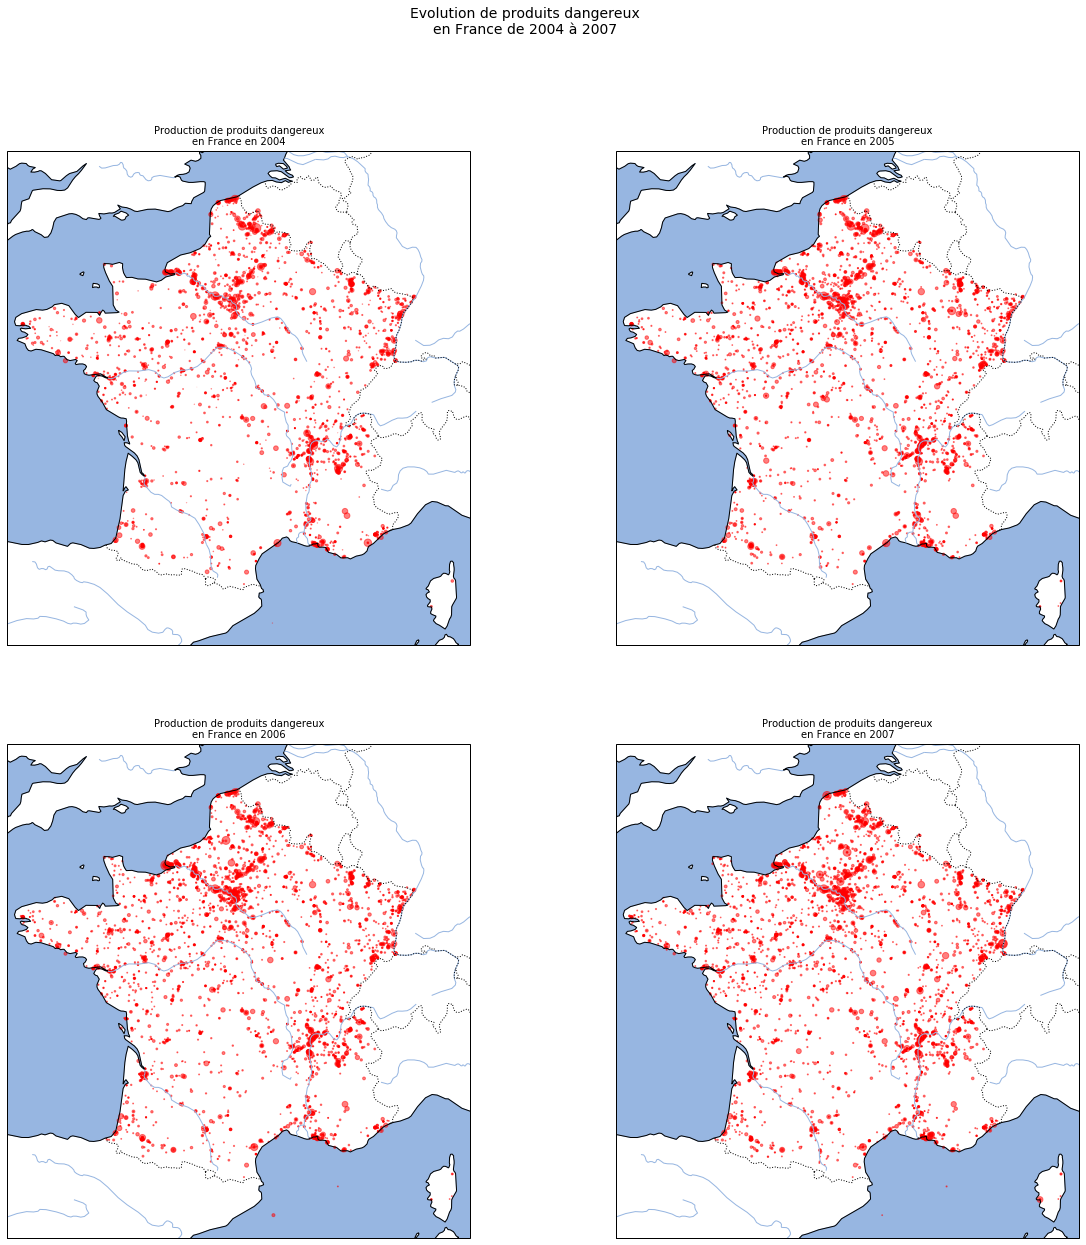

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(20,20), subplot_kw={'projection': ccrs.Mercator()})
x, y = df_metro['LLX'], df_metro['LLY']
years = range(2004, 2008)

years_str = [str(year) for year in years]
values = df_metro[[colname for colname in df_metro.columns.values if colname[-4:] in years_str]].astype('float')

plot_geo_time_value(x, y, year=years, value=values, proj='mercator', axs=axs, hue='produits dangereux')

### De 2004 à 2007, en PlateCarree

#### Le fichier pdf généré par la cellule ci-dessous est visible à [cette adresse](https://files.catbox.moe/ja2jet.pdf)

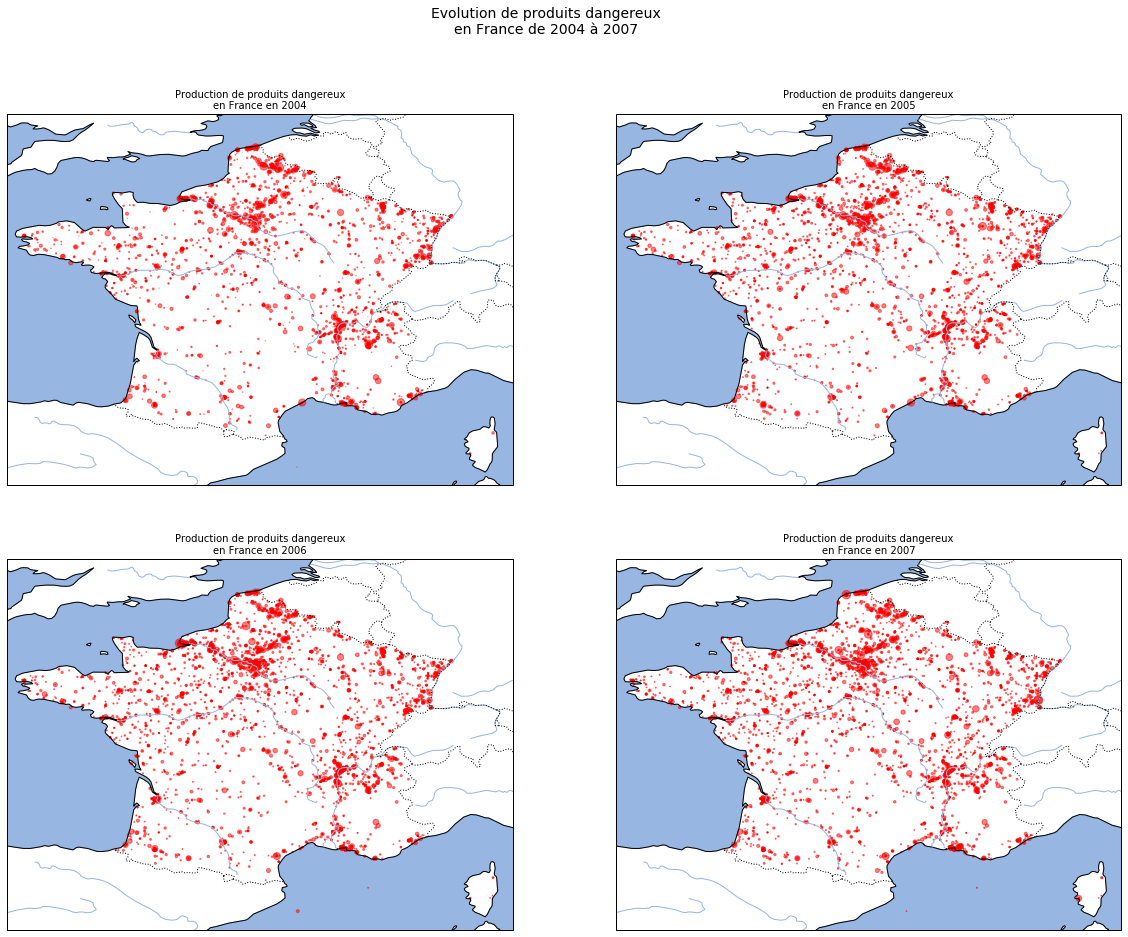

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(20,15), subplot_kw={'projection': ccrs.PlateCarree()})

x, y = df_metro['LLX'], df_metro['LLY']
years = range(2004, 2008)

years_str = [str(year) for year in years]
values = df_metro[[colname for colname in df_metro.columns.values if colname[-4:] in years_str]].astype('float')

plot_geo_time_value(x, y, year=years, value=values, proj='plate', axs=axs, hue='produits dangereux')

### Gif de 2003 à 2017, en Mercator

#### Le fichier gif généré par la cellule ci-dessous est visible à [cette adresse](https://files.catbox.moe/38yndo.gif)

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


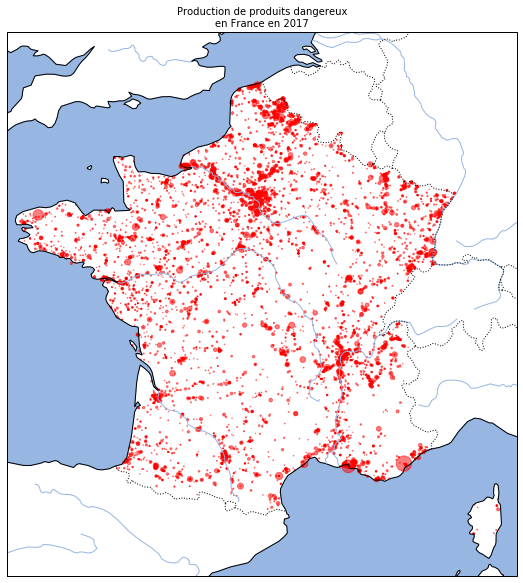

In [9]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.Mercator()})

x, y = df_metro['LLX'], df_metro['LLY']
years = range(2003, 2018)

years_str = [str(year) for year in years]
values = df_metro[[colname for colname in df_metro.columns.values if colname[-4:] in years_str]].astype('float')

plot_gif_geo_time_value(x, y, value=values, year=years, fig=fig, ax=ax, proj='mercator', method='gif', hue='produits dangereux')